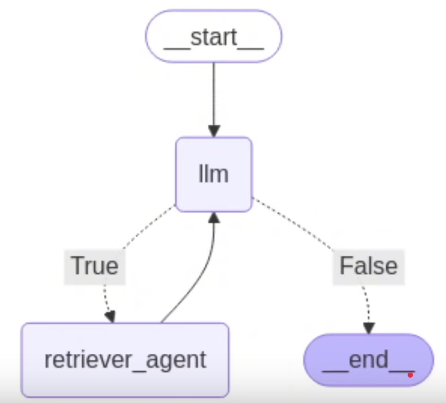

In [15]:
from typing import Annotated, Sequence, TypedDict
from dotenv import load_dotenv
import os  
from langchain_core.messages import BaseMessage, HumanMessage, ToolMessage, SystemMessage
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma
from langchain_core.tools import tool
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode

load_dotenv()

True

In [16]:
llm = ChatOpenAI(
    model="gpt-4o", temperature = 0) # I want to minimize hallucination - temperature = 0 makes the model output more deterministic 

# Our Embedding Model - has to also be compatible with the LLM
embeddings = OpenAIEmbeddings(
    model="text-embedding-3-small",
)

pdf_path = "Stock_Market_Performance_2024.pdf"

# Safety measure I have put for debugging purposes :)
if not os.path.exists(pdf_path):
    raise FileNotFoundError(f"PDF file not found: {pdf_path}")

pdf_loader = PyPDFLoader(pdf_path) # This loads the PDF

# Checks if the PDF is there
try:
    pages = pdf_loader.load()
    print(f"PDF has been loaded and has {len(pages)} pages")
except Exception as e:
    print(f"Error loading PDF: {e}")
    raise


PDF has been loaded and has 9 pages


In [17]:
# Chunking Process
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200
)

pages_split = text_splitter.split_documents(pages) # We now apply this to our pages

In [18]:
persist_directory = r"C:\Users\sevgi\ChromaDB\LangGraphCourse\RAG-agent"
collection_name = "stock_market"

# If our collection does not exist in the directory, we create using the os command
if not os.path.exists(persist_directory):
    os.makedirs(persist_directory)


try:
    # Here, we actually create the chroma database using our embeddigns model
    vectorstore = Chroma.from_documents(
        documents=pages_split,
        embedding=embeddings,
        persist_directory=persist_directory,
        collection_name=collection_name
    )
    print(f"Created ChromaDB vector store!")
    
except Exception as e:
    print(f"Error setting up ChromaDB: {str(e)}")
    raise


# Now we create our retriever 
retriever = vectorstore.as_retriever(
    search_type="similarity",
    search_kwargs={"k": 5} # K is the amount of chunks to return
)

Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given


Created ChromaDB vector store!


In [19]:
@tool
def retriever_tool(query: str) -> str:
    """
    This tool searches and returns the information from the Stock Market Performance 2024 document.
    """

    docs = retriever.invoke(query)

    if not docs:
        return "I found no relevant information in the Stock Market Performance 2024 document."
    
    results = []
    for i, doc in enumerate(docs):
        results.append(f"Document {i+1}:\n{doc.page_content}")
    
    return "\n\n".join(results)

tools = [retriever_tool]

llm = llm.bind_tools(tools)

In [20]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

def should_continue(state: AgentState):
    """Check if the last message contains tool calls."""
    result = state['messages'][-1]
    return hasattr(result, 'tool_calls') and len(result.tool_calls) > 0


In [21]:

system_prompt = """
You are an intelligent AI assistant who answers questions about Stock Market Performance in 2024 based on the PDF document loaded into your knowledge base.
Use the retriever tool available to answer questions about the stock market performance data. You can make multiple calls if needed.
If you need to look up some information before asking a follow up question, you are allowed to do that!
Please always cite the specific parts of the documents you use in your answers.
"""

tools_dict = {our_tool.name: our_tool for our_tool in tools} # Creating a dictionary of our tools

# LLM Agent
def call_llm(state: AgentState) -> AgentState:
    """Function to call the LLM with the current state."""
    messages = list(state['messages'])
    messages = [SystemMessage(content=system_prompt)] + messages
    message = llm.invoke(messages)
    return {'messages': [message]}


# Retriever Agent
def take_action(state: AgentState) -> AgentState:
    """Execute tool calls from the LLM's response."""

    tool_calls = state['messages'][-1].tool_calls
    results = []
    for t in tool_calls:
        print(f"Calling Tool: {t['name']} with query: {t['args'].get('query', 'No query provided')}")
        
        if not t['name'] in tools_dict: # Checks if a valid tool is present
            print(f"\nTool: {t['name']} does not exist.")
            result = "Incorrect Tool Name, Please Retry and Select tool from List of Available tools."
        
        else:
            result = tools_dict[t['name']].invoke(t['args'].get('query', ''))
            print(f"Result length: {len(str(result))}")
            

        # Appends the Tool Message
        results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))

    print("Tools Execution Complete. Back to the model!")
    return {'messages': results}


In [22]:
graph = StateGraph(AgentState)
graph.add_node("llm", call_llm)
graph.add_node("retriever_agent", take_action)

graph.add_conditional_edges(
    "llm",
    should_continue,
    {True: "retriever_agent", False: END}
)
graph.add_edge("retriever_agent", "llm")
graph.set_entry_point("llm")

rag_agent = graph.compile()

In [23]:
def running_agent():
    print("\n=== RAG AGENT===")
    
    while True:
        user_input = input("\nWhat is your question: ")
        if user_input.lower() in ['exit', 'quit']:
            break
            
        messages = [HumanMessage(content=user_input)] # converts back to a HumanMessage type

        result = rag_agent.invoke({"messages": messages})
        
        print("\n=== ANSWER ===")
        print(result['messages'][-1].content)


running_agent()


=== RAG AGENT===
Calling Tool: retriever_tool with query: S&P 500 performance in 2024
Result length: 4919
Tools Execution Complete. Back to the model!

=== ANSWER ===
In 2024, the S&P 500 index delivered a total return of approximately 25%, with around 23% in price terms. This marked the second consecutive year of over 20% returns for the S&P 500, a feat not observed since the late 1990s. The performance was significantly driven by the dominance of mega-cap technology stocks, often referred to as the "Magnificent 7," which included companies like Apple, Microsoft, Alphabet (Google), Amazon, Meta, Nvidia, and Tesla. These companies collectively surged by roughly 64-67% on average in 2024 and accounted for over half of the S&P 500's return for the year (about 54% of the performance) [Document 1, Document 3].
Calling Tool: retriever_tool with query: OpenAI stock performance 2024
Result length: 4745
Tools Execution Complete. Back to the model!

=== ANSWER ===
The documents do not provide 